## Polygon Tutorial 2
Using data **segmentation** and module ***shapely*** to transform dataset to polygon boxes.
<br> COCO dataset as an example.

In [1]:
import json
import pycocotools
import shapely
import shapely.geometry
import glob
import numpy as np
import os

from pathlib import Path
from itertools import repeat
from tqdm import tqdm
from pycocotools import coco, mask

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

oneD2twoD = lambda x: [(x[2*i], x[2*i+1]) for i in range(len(x)//2)]   # one D [x, y, x, y, x, y, ...] to [(x, y), (x, y), ...]
catid_to_idx = {1: 0, 2: 1, 3: 2, 4: 3, 5: 4, 6: 5, 7: 6, 8: 7, 9: 8, 
               10: 9, 11: 10, 13: 11, 14: 12, 15: 13, 16: 14, 17: 15, 
               18: 16, 19: 17, 20: 18, 21: 19, 22: 20, 23: 21, 24: 22, 
               25: 23, 27: 24, 28: 25, 31: 26, 32: 27, 33: 28, 34: 29, 
               35: 30, 36: 31, 37: 32, 38: 33, 39: 34, 40: 35, 41: 36, 
               42: 37, 43: 38, 44: 39, 46: 40, 47: 41, 48: 42, 49: 43, 
               50: 44, 51: 45, 52: 46, 53: 47, 54: 48, 55: 49, 56: 50, 
               57: 51, 58: 52, 59: 53, 60: 54, 61: 55, 62: 56, 63: 57, 
               64: 58, 65: 59, 67: 60, 70: 61, 72: 62, 73: 63, 74: 64, 
               75: 65, 76: 66, 77: 67, 78: 68, 79: 69, 80: 70, 81: 71, 
               82: 72, 84: 73, 85: 74, 86: 75, 87: 76, 88: 77, 89: 78, 90: 79}


def seg2poly(dataset_path='',
             plot=True,):
    """
        Transform segmentation to polygon labels (x1, y1, x2, y2, x3, y3, x4, y4)
    """
    
    # Search for COCO json annotation files
    f = []  # json files
    p = Path(dataset_path)
    assert p.is_dir(), "'dataset_path' should be a valid path."
    f += glob.glob(str(p / '**' / '*.json'), recursive=True)
    assert f, f"Error: no searched annotations files (.json) with {dataset_path}"
    
    # Iterate through each json_file
    for json_file in f:
        coco_data = pycocotools.coco.COCO(json_file) # load coco data
        
        parent_path = Path(json_file).parent.parent
        img_txt = [] # store searched image files
        img_dir = parent_path / 'images'
        
        # Get prefix name
        for file in os.listdir(str(img_dir)):
            if file in json_file:
                prefix = file
                break
        
        img_dir = img_dir / prefix
        anno_dir = parent_path / 'labels' / prefix
        if not os.path.exists(str(anno_dir)): os.mkdir(str(anno_dir))
        
        print(f'Begin transformation for {prefix}')
        plot_now = 0
        for img_i, img in enumerate(tqdm(coco_data.dataset['images'])):
            
            plot = plot and plot_now<3 # test the first three images that are not crowded
            img_name = img_dir / img['file_name']
            if img_name.exists():
                anno_name = anno_dir / (os.path.splitext(img['file_name'])[0]+'.txt')
                anno_txt = [] # store label information

                if img['id'] not in coco_data.imgToAnns.keys(): continue
                img_txt.append(str(img_name)) # store current image file

                if plot: polygon_coords, segment_coords = [], [] # for plot

                # iterate through each object
                for object0 in coco_data.imgToAnns[img['id']]:

                    # if not crowded, use segmentation
                    if not object0['iscrowd']:
                        segments = [oneD2twoD(segment+segment[:2]) 
                                           for segment in object0['segmentation']]
                        if plot: 
                            polygon_coords.append([])
                            segment_coords.append([])

                    # if crowded, use bbox
                    else: 
                        # x1, y1, x1, y2, x2, y2, x2, y1
                        label = [catid_to_idx[object0['category_id']],
                                 object0['bbox'][0], object0['bbox'][1], object0['bbox'][0], object0['bbox'][3],
                                 object0['bbox'][2], object0['bbox'][3], object0['bbox'][2], object0['bbox'][0]] 

                        label = normalize_anchors(label, img['height'], img['width'])[0] # normalize xyxyxyxy
                        anno_txt.append(label)
                        continue

                    # iterate through each segmentation
                    for segment in segments:

                        #using shapely::minimum_rotated_rectangle to convert segmentation
                        multipoint = shapely.geometry.MultiPoint(segment)
                        # polygon: class id, x1, y1, x2, y2, x3, y3, x4, y4 (unnormalized)
                        try:
                            label = [catid_to_idx[object0['category_id']],
                                     *np.array(multipoint.minimum_rotated_rectangle.exterior.coords[:-1]).ravel().tolist()]
                            label, label_pixel = normalize_anchors(label, img['height'], img['width']) # normalize xyxyxyxy
                            anno_txt.append(label)
                            if plot: 
                                polygon_coords[-1].append(np.vstack((label_pixel[1:].reshape(-1, 2), label_pixel[1:3])))
                                segment_coords[-1].append(segment)
                        except Exception as e:
                            print('Warning: Ignore label, ', e)
                if plot: 
                    polygon_plot_image(img_name, polygon_coords, segment_coords)
                    plot_now += 1
                np.savetxt(str(anno_name), np.array(anno_txt), fmt=["%i"]+["%.6f"]*8)
        with open(str(parent_path/(prefix+'.txt')), 'w+') as f:
            for img_i, img_name in enumerate(img_txt):
                if img_i == len(img_txt)-1: f.write(img_name)
                else: f.write(img_name+'\n')


def normalize_anchors(label, img_h, img_w):
    """
        polygon
        FROM class id, x1, y1, x2, y2, x3, y3, x4, y4 (unnormalized)
        TO class id (unchanged), x1, y1, x2, y2, x3, y3, x4, y4 (normalized to [0, 1])
    """
    label = np.array(label)
    label_pixel = np.copy(label)
    label[1::2] = label[1::2].clip(0., img_w)/img_w
    label[2::2] = label[2::2].clip(0., img_h)/img_h
    label_pixel[1::2] = label_pixel[1::2].clip(0., img_w)
    label_pixel[2::2] = label_pixel[2::2].clip(0., img_h)
    return label, label_pixel
        
def polygon_plot_image(img_name, polygon_coords, segment_coords=None):
    img = mpimg.imread(img_name)
    plt.figure(figsize=(12, 8))
    plt.imshow(img)
    if segment_coords is not None:
        for seg_coo in segment_coords:
            for segment in seg_coo:
                plt.plot(*list(zip(*segment)))
    for poly_coo in polygon_coords:
        for polygon in poly_coo:
            plt.plot(*list(zip(*polygon)))
    plt.axis('off')
    plt.show()

loading annotations into memory...


  0%|          | 0/5000 [00:00<?, ?it/s]

Done (t=0.59s)
creating index...
index created!
Begin transformation for val2017


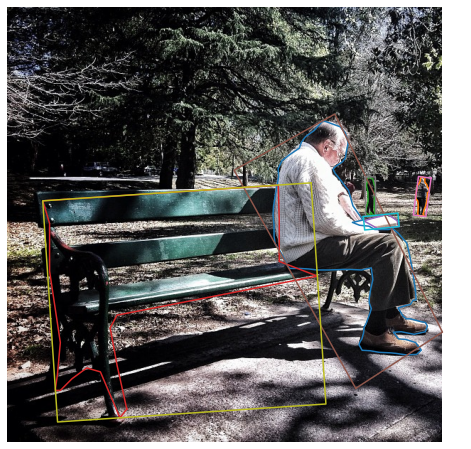

  5%|▌         | 269/5000 [00:00<00:04, 999.21it/s]

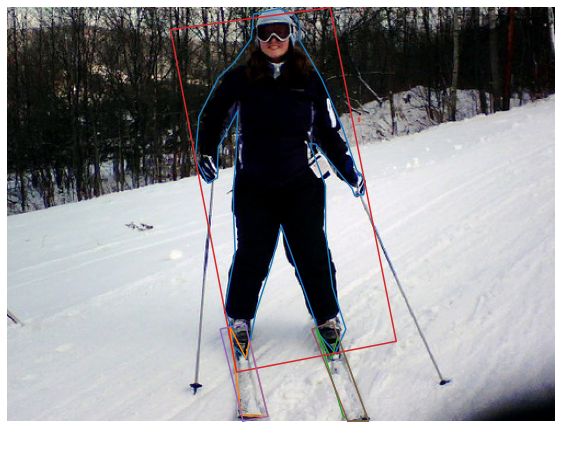

  9%|▊         | 428/5000 [00:00<00:05, 813.02it/s]

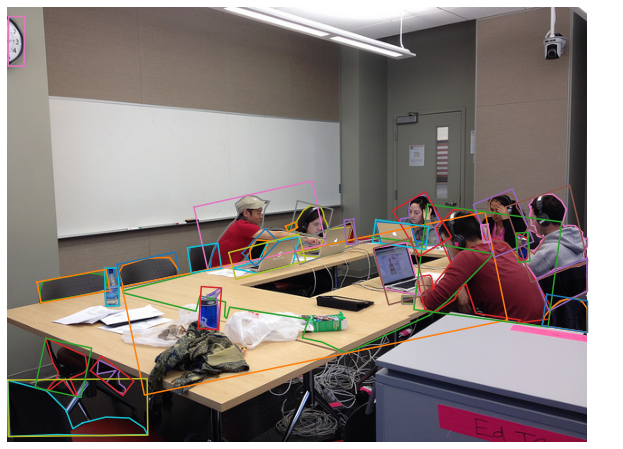

100%|██████████| 5000/5000 [00:01<00:00, 4230.96it/s]


In [2]:
seg2poly('/home/xinzeli831/PolygonObjectDetection/coco20', plot=True)